In [6]:
import os
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# ImageDataGenerator 설정
data_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

# train_generator 생성
train_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/cnn/train',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
)

validation_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/cnn/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = data_generator.flow_from_directory(
    '/content/drive/MyDrive/cnn/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)


Found 9000 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.
Found 861 images belonging to 3 classes.


In [12]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
EfficientNetB0_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/cnn/checkpoint/e",
    save_best_only=True,
    monitor='val_loss',
)


EfficientNetB0_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=EfficientNetB0_model.fit(train_generator, epochs=30,validation_data=validation_generator, callbacks=[checkpoint_callback])

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/30
71/71 [==============================] - 118s 2s/step - loss: 1.1487 - accuracy: 0.3553 - val_loss: 1.0890 - val_accuracy: 0.3667
Epoch 2/30
71/71 [==============================] - 105s 1s/step - loss: 1.0903 - accuracy: 0.3822 - val_loss: 1.0783 - val_accuracy: 0.4517
Epoch 3/30
71/71 [==============================] - 104s 1s/step - loss: 1.0849 - accuracy: 0.3949 - val_loss: 1.0690 - val_accuracy: 0.4044
Epoch 4/30
71/71 [==============================] - 114s 2s/step - loss: 1.0748 - accuracy: 0.4129 - val_loss: 1.0576 - val_accuracy: 0.4272
Epoch 5/30
71/71 [==============================] - 75s 1s/step - loss: 1.0672 - accuracy: 0.4268 - val_loss: 1.0804 - val_accuracy: 0.3917
Epoch 6/30
71/71 [==============================] - 107s 2s/step - loss: 1.0649 - accuracy: 0.4267 - val_loss: 1.0419 - val_accuracy: 0.5200
Epoch 7/30
71/71 [==============================] - 107s 2s/step - loss: 1.0641 - accuracy

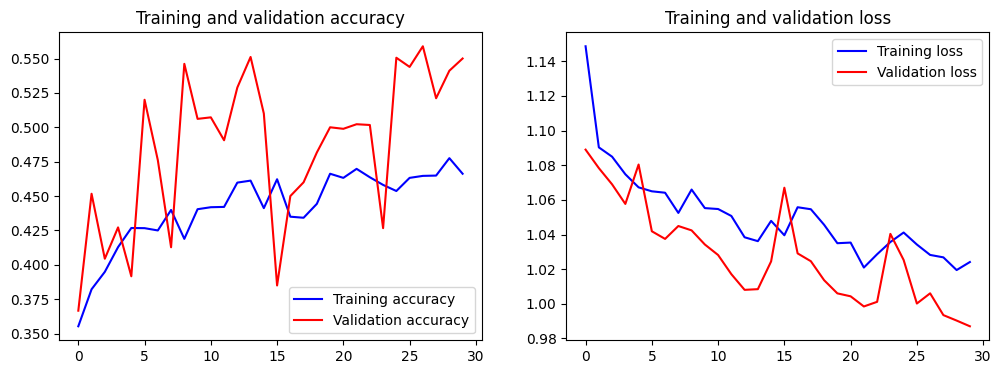

27/27 [==============================] - 365s 14s/step - loss: 1.0453 - accuracy: 0.4437
Test Accuracy: 0.4436701536178589
27/27 [==============================] - 8s 202ms/step


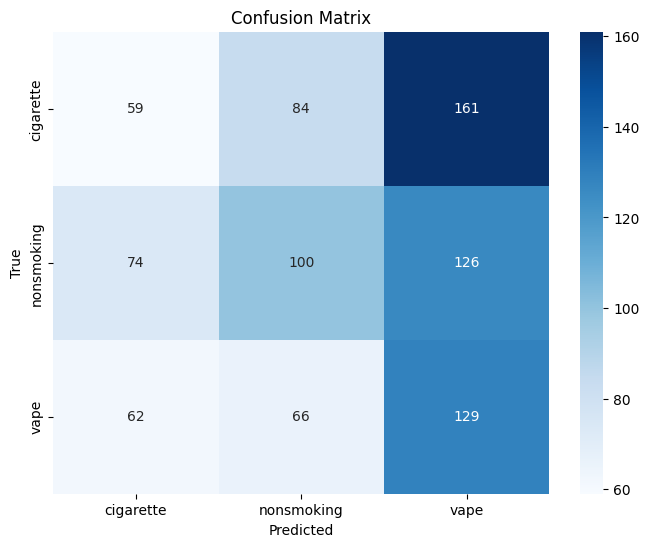

              precision    recall  f1-score   support

   cigarette       0.30      0.19      0.24       304
  nonsmoking       0.40      0.33      0.36       300
        vape       0.31      0.50      0.38       257

    accuracy                           0.33       861
   macro avg       0.34      0.34      0.33       861
weighted avg       0.34      0.33      0.32       861



In [14]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = EfficientNetB0_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = EfficientNetB0_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)